In [328]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp

In [329]:
# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# ##Esto es para renderizar texto con LaTex
plt.rc('text', usetex = True)
SMALL_SIZE = 25
MEDIUM_SIZE = 32
BIGGER_SIZE = 37

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['figure.figsize'] = (7, 5)

Constantes:

In [330]:
j2pi = 1j*2*np.pi
KHZ = 1e3 
MIN_FREQ = 435*KHZ
MAX_FREQ = 438*KHZ
CHANNEL_BW = 0.5*KHZ
NO_CHANNELS = int((MAX_FREQ - MIN_FREQ) / CHANNEL_BW)
SAMPLING_RATE = int(65*KHZ)
TS = 1/(65*KHZ)
FULL_ANALOG_BW = int(650*KHZ)

Función para hacer la DFFT:

In [331]:
def computeFT(vector, Ts):
    longitud = len(vector)
    transformada = np.fft.fftshift(np.fft.fft(vector))
    
    vectorDeFrecs = np.array([(-1/2+i/longitud)/Ts for i in range(longitud)])
    return transformada, vectorDeFrecs

## Ejemplo de muestreo pasabanda

Genero un tono a 436 KHz, el cual muestreo a 65 KHz.

In [332]:
t = np.linspace(0,1,num=SAMPLING_RATE)
tono = np.cos(2*np.pi*436*KHZ*t)

In [333]:
fft, freqs = computeFT(tono, TS)

La primer zona de Nyquist está en el rango de [-32,5; 32,5] KHz. Recién la séptima réplica cae allí dentro:

436 KHz - 7*65 KHz = -19 KHz => Vemos un tono de 19 KHz

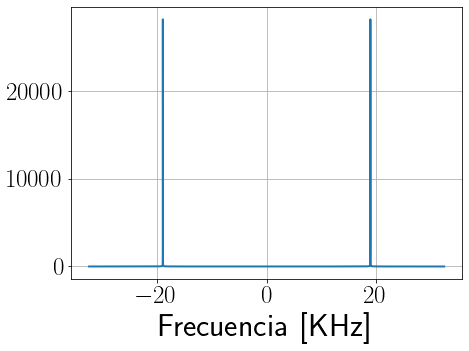

In [334]:
plt.plot(freqs*10**-3, np.abs(fft), lw=2)
plt.xlabel("Frecuencia [KHz]")
plt.grid()

## Generación y muestreo de señal

In [335]:
def generateTriangle(num):
    _middlePoint = int(num/2)
    _positiveLine = lambda x : x/_middlePoint
    _negativeLine = lambda x : (num - x) / _middlePoint
    triangle = np.zeros(num)
    for i in range(num):
        if(i < _middlePoint):
            triangle[i] = _positiveLine(i)
        else:
            triangle[i] = _negativeLine(i)
    return triangle

In [336]:
freqs = np.linspace(- FULL_ANALOG_BW, FULL_ANALOG_BW, num=int(2*FULL_ANALOG_BW))
values = np.zeros(2*FULL_ANALOG_BW)
triangleLength = int(CHANNEL_BW)
triangle = generateTriangle(triangleLength)


In [337]:
for i in range(NO_CHANNELS):
    values[int(212_000 + i*CHANNEL_BW) : int(212_000+(i+1)*CHANNEL_BW )] = triangle
    values[int(1_085_000 + i*CHANNEL_BW) : int(1_085_000+(i+1)*CHANNEL_BW )] = triangle

(-433.0, -440.0)

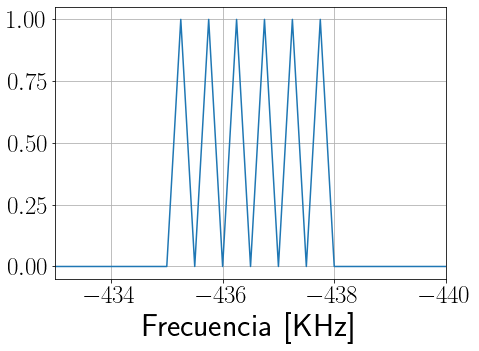

In [338]:
plt.plot(freqs*10**-3, values)
plt.xlabel("Frecuencia [KHz]")
plt.grid()
plt.xlim(-433,-440)

In [339]:
signal_td = np.fft.ifft(values)

In [340]:
muestreo = np.zeros(SAMPLING_RATE)
for i in range(SAMPLING_RATE):
    muestreo[i] = signal_td[i*20]

<ipython-input-340-437ea43de004>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  muestreo[i] = signal_td[i*20]


In [341]:
fft, freqs = computeFT(vector=muestreo, Ts=TS)

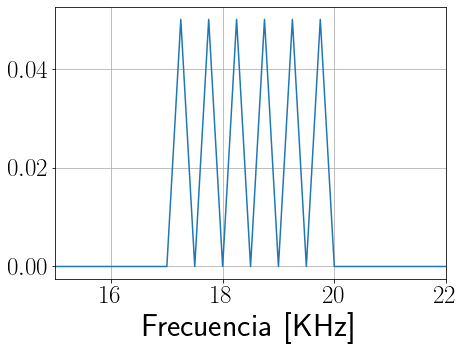

In [342]:
plt.plot(freqs*10**-3, np.abs(fft))
plt.xlim(15,22)
plt.xlabel("Frecuencia [KHz]")
plt.grid()

## Definición de clases

In [343]:
class Sampler:
    def __init__(self, fs):
        self.fs = fs
        
    def sample(self, signal):
        length = len(signal)
        ratio = int(length/self.fs)
        sampledSignal = np.zeros(self.fs, dtype='complex128')
        for i in range(self.fs):
            sampledSignal[i] = signal[i*ratio]
        return sampledSignal
    
class BandpassFilter:
    def __init__(self, fc_1, fc_2):
        order = 4
        self.fc_1 = fc_1
        self.fc_2 = fc_2
        self.num, self.den = sp.butter(order, (2*fc_1/SAMPLING_RATE, 2*fc_2/SAMPLING_RATE), btype='bandpass')
    def apply(self, signal):
        filtered = sp.lfilter(self.num, self.den, signal)
        return filtered
    
class DDC:
    def __init__(self, centralFreq, BW, currentFs, decimationFactor):
        #NCO
        t = np.linspace(0,1,num=currentFs)
        self.NCO = np.exp(-j2pi*centralFreq*t)
        #Filter
        order = 4        
        self.filterCoefs = sp.butter(order, 2*BW/currentFs)
        #Decimator
        self.fs = int(currentFs/decimationFactor)
        self.sampler = Sampler(self.fs)
        
    def apply(self, signal):
        mixed = self.NCO * signal
        filtered = sp.lfilter(self.filterCoefs[0], self.filterCoefs[1], mixed)
        sampled = self.sampler.sample(filtered)
        return sampled

## Test con espectro lleno de triángulos

In [344]:
class Signal:
    def __init__(self):
        self.freqs = np.linspace(- FULL_ANALOG_BW, FULL_ANALOG_BW, num=int(2*FULL_ANALOG_BW))
        values = np.zeros(int(2*FULL_ANALOG_BW))
        triangleLength = int(CHANNEL_BW)
        triangle = generateTriangle(triangleLength)
        for i in range(int(2*FULL_ANALOG_BW/CHANNEL_BW)):            
            values[i*triangleLength: (i+1)*triangleLength] = triangle
        self.values = values
                
    def inTimeDomain(self):
        return np.fft.fftshift(np.fft.ifft(self.values))
        

In [345]:
signal = Signal()

(435.0, 440.0)

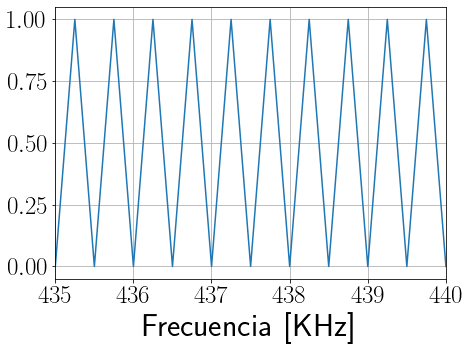

In [346]:
plt.plot(signal.freqs*10**-3, signal.values)
plt.xlabel("Frecuencia [KHz]")
plt.grid()
plt.xlim(435, 440)

In [347]:
sampler = Sampler(SAMPLING_RATE)
sampledSignal = sampler.sample(signal.inTimeDomain())


In [348]:
BP_Filter = BandpassFilter(fc_1=17_000, fc_2=20_000)

In [349]:
filteredSignal = BP_Filter.apply(sampledSignal)

In [350]:
fft, freqs = computeFT(filteredSignal, TS)

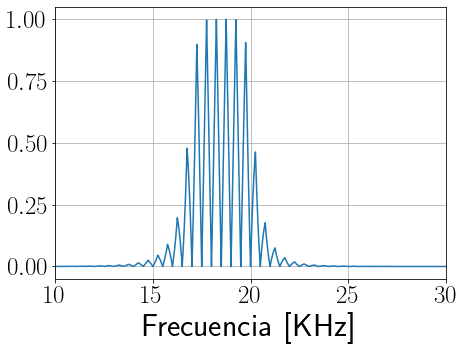

In [351]:
plt.plot(freqs*10**-3, np.abs(fft))
plt.xlim([10,30])
plt.xlabel("Frecuencia [KHz]")
plt.grid()

In [352]:
ddc = DDC(centralFreq=18_500, BW=3000, currentFs=SAMPLING_RATE, decimationFactor=9.28)

In [353]:
ddc_signal = ddc.apply(filteredSignal)

In [354]:
fft, freqs = computeFT(ddc_signal, 5/SAMPLING_RATE)

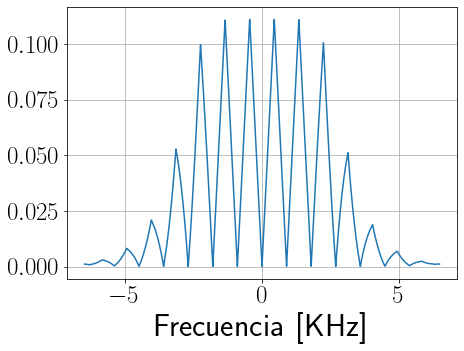

In [355]:
plt.plot(freqs*10**-3, abs(fft))
plt.xlabel("Frecuencia [KHz]")
plt.grid()

# Tríangulos con ruido

In [356]:
class NoisySignal:
    def __init__(self):        
        self.freqs = np.linspace(- FULL_ANALOG_BW, FULL_ANALOG_BW, num=int(2*FULL_ANALOG_BW))
        values = np.zeros(int(2*FULL_ANALOG_BW))
        triangleLength = int(CHANNEL_BW)
        triangle = generateTriangle(triangleLength)
        for i in range(NO_CHANNELS):            
            values[int(212_000 + i*CHANNEL_BW) : int(212_000+(i+1)*CHANNEL_BW )] = triangle
            values[int(1_085_000 + i*CHANNEL_BW) : int(1_085_000+(i+1)*CHANNEL_BW )] = triangle
        self.values = values + np.random.randn(int(2*FULL_ANALOG_BW))*0.05
    def inTimeDomain(self):
        return np.fft.fftshift(np.fft.ifft(self.values))
                

In [357]:
signal = NoisySignal()

Text(0.5, 0, 'Frecuencia [KHz]')

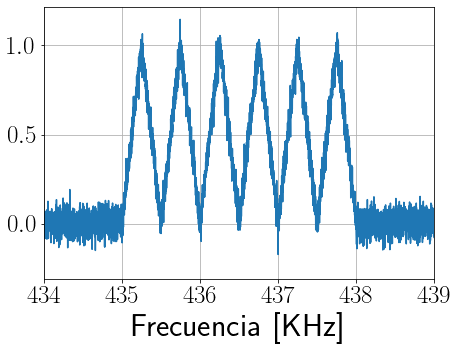

In [366]:
plt.plot(signal.freqs*10**-3, signal.values)
plt.xlim(434,439)
plt.grid()
plt.xlabel("Frecuencia [KHz]")

Text(0.5, 0, 'Frecuencia [KHz]')

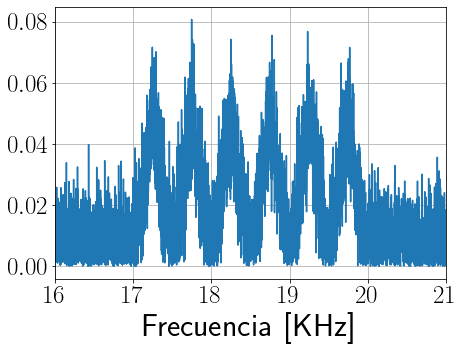

In [368]:
sampler = Sampler(fs=SAMPLING_RATE)
sampledSignal = sampler.sample(signal.inTimeDomain())
fft, freqs = computeFT(sampledSignal, TS)
plt.plot(freqs*10**-3, np.abs(fft))
plt.xlim(16,21)
plt.grid()
plt.xlabel("Frecuencia [KHz]")

Text(0.5, 0, 'Frecuencia [KHz]')

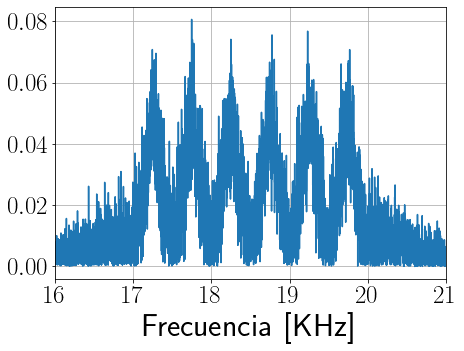

In [369]:
BP_Filter = BandpassFilter(fc_1=16500, fc_2=20500)
filteredSignal = BP_Filter.apply(sampledSignal)
fft, freqs = computeFT(filteredSignal, TS)
plt.plot(freqs*10**-3, np.abs(fft))
plt.xlim(16,21)
plt.grid()
plt.xlabel("Frecuencia [KHz]")

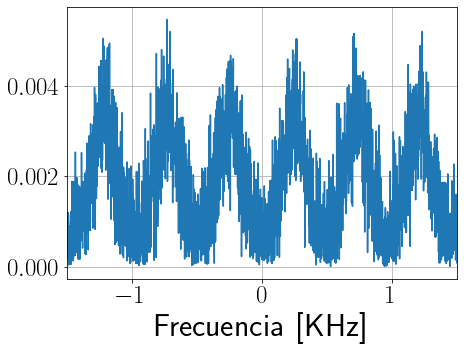

In [370]:
ddc = DDC(centralFreq=18.5*KHZ, BW=3*KHZ, currentFs=SAMPLING_RATE, decimationFactor=SAMPLING_RATE/(1.5*3*KHZ))
decimatedSignal = ddc.apply(filteredSignal)
fft, freqs = computeFT(decimatedSignal, 1/ddc.fs)
plt.plot(freqs*10**-3, np.abs(fft))
plt.xlim(-1.5,1.5)
plt.xlabel("Frecuencia [KHz]")
plt.grid()
plt.axvline(-1250,c='r', lw=3)
plt.axvline(-750,c='r', lw=3)
plt.axvline(-250,c='r', lw=3)
plt.axvline(250,c='r', lw=3)
plt.axvline(750,c='r', lw=3)
plt.axvline(1250,c='r', lw=3)

## Selección de canal

In [362]:
def getChannel(signal, centralFreq, BW, currentFs):
    decimationFactor = currentFs/(2*BW)
    ddc = DDC(centralFreq=centralFreq, BW=BW, currentFs=currentFs, decimationFactor=decimationFactor)
    channel = ddc.apply(signal)
    return channel
    

In [363]:
channels = np.zeros([NO_CHANNELS, 1000], dtype='complex128')
for i in range(NO_CHANNELS):
    channels[i] = getChannel(signal=decimatedSignal, centralFreq = -1250 + i*500, BW=CHANNEL_BW, currentFs=ddc.fs)

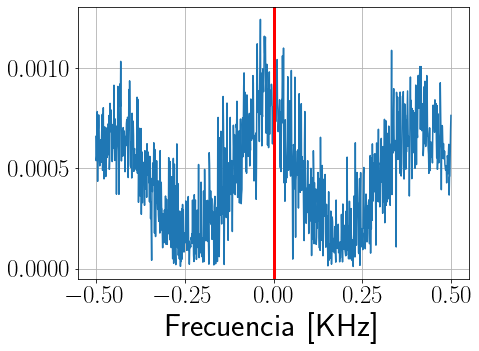

In [371]:
fft, freqs = computeFT(channels[4], 0.001)
plt.plot(freqs*10**-3, abs(fft))
plt.axvline(0, c='r', lw=3)
plt.xlabel("Frecuencia [KHz]")
plt.grid()